In [32]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import (
    Dense,
    LSTM,
    Concatenate,
    BatchNormalization,
    LayerNormalization,
    Dropout,
)
from keras import Model
import pandas as pd
from sklearn.metrics import log_loss

# Loads preprocessed data

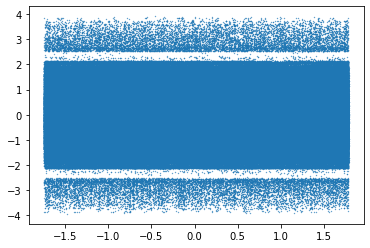

In [33]:
load_path = r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\data\processed"

event_X_train = pd.read_pickle(os.path.join(load_path, "event_X_train.pkl"))
event_X_test = pd.read_pickle(os.path.join(load_path, "event_X_test.pkl"))

y_train = pd.read_pickle(os.path.join(load_path, "y_train.pkl"))
y_test = pd.read_pickle(os.path.join(load_path, "y_test.pkl"))

object_X_train = np.load(os.path.join(load_path, "object_X_train.npy"))
object_X_test = np.load(os.path.join(load_path, "object_X_test.npy"))

plt.scatter(object_X_train[:, :, 7], object_X_train[:, :, 4], s=0.1)

# Hyperparameters

In [55]:
ACTIVATION = "relu"


def f1_score(y_true, y_pred):  # taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val


METRICS = [
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.AUC(name="AUC"),
    f1_score,
]

class_weights = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
class_weights = {l: c for l, c in zip(np.unique(y_train), class_weights)}

MONITOR = "val_loss"
MODE = "auto"

# stops training early if score doesn't improve
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor=MONITOR,
    verbose=1,
    patience=2,
    mode=MODE,
    restore_best_weights=True,
)


# Hyperparameter Optimization using Bayesian Optimization

In [57]:
def create_model(params):
    DNN_model = Sequential()
    DNN_model.add(
        Dense(params["units1"], input_shape=(event_X_train.shape[1],), activation=ACTIVATION)
    )
    DNN_model.add(BatchNormalization())
    DNN_model.add(Dropout(params["dropout"]))

    RNN_model = Sequential()

    if params["lstm_layer_2"]:
        RNN_model.add(
            LSTM(
                params["units2"],
                input_shape=(object_X_train.shape[1], object_X_train.shape[2]),
                activation="tanh",
                return_sequences=True,
                recurrent_dropout=params["re_dropout"],
            )
        )
        RNN_model.add(LayerNormalization(axis=-1, center=True, scale=True))

        RNN_model.add(
            LSTM(
                params["units2"],
                input_shape=(object_X_train.shape[1], object_X_train.shape[2]),
                activation="tanh",
                recurrent_dropout=params["re_dropout"],
            )
        )
        RNN_model.add(LayerNormalization(axis=-1, center=True, scale=True))

    else:
        RNN_model.add(
            LSTM(
                params["units2"],
                input_shape=(object_X_train.shape[1], object_X_train.shape[2]),
                activation="tanh",
                recurrent_dropout=params["re_dropout"],
            )
        )
        RNN_model.add(LayerNormalization(axis=-1, center=True, scale=True))

    merged_model = Concatenate()([DNN_model.output, RNN_model.output])
    merged_model = Dense(params["units3"], activation=ACTIVATION)(merged_model)
    merged_model = BatchNormalization()(merged_model)
    merged_model = Dropout(params["dropout"])(merged_model)

    if params["merged_layer_2"]:
        merged_model = Dense(params["units3"], activation=ACTIVATION)(merged_model)
        merged_model = BatchNormalization()(merged_model)
        merged_model = Dropout(params["dropout"])(merged_model)

        if params["merged_layer_3"]:
            merged_model = Dense(params["units3"], activation=ACTIVATION)(merged_model)
            merged_model = BatchNormalization()(merged_model)
            merged_model = Dropout(params["dropout"])(merged_model)

    merged_model = Dense(1, activation="sigmoid")(merged_model)
    model = Model(inputs=[DNN_model.input, RNN_model.input], outputs=merged_model)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=params["lr"]),
        loss="binary_crossentropy",
        metrics=METRICS,
    )

    return model


def train_and_evaluate(params, model):
    model.fit(
        [event_X_train, object_X_train],
        y_train,
        batch_size=params["batch_size"],
        class_weight=class_weights,
        epochs=100,
        callbacks=[early_stopping, KerasPruningCallback(trial, "val_loss")],
        validation_data=([event_X_test, object_X_test], y_test),
        shuffle=True,
        verbose=1,
    )

    preds = model.predict([event_X_test, object_X_test])
    loss = log_loss(y_test, preds)

    return loss

In [72]:
import logging
import sys

db_path = r"C:\Users\Noaja\Downloads\msci_project\tth-ML-project\models"

# Add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "bayesian_opt_v1"  # Unique identifier of the study.
storage_name = f"sqlite:///{study_name}.db"

In [ ]:
import optuna
from optuna.integration import KerasPruningCallback

def objective(trial):
    params = {
        "units1": trial.suggest_int("dnn_units", 40, 300, 20),
        "units2": trial.suggest_int("lstm_units", 40, 300, 20),
        "units3": trial.suggest_int("merged_units", 40, 300, 20),
        "dropout": trial.suggest_uniform("dropout", 0.0, 0.5),
        "re_dropout": trial.suggest_uniform("redroput", 0.0, 0.5),
        "merged_layer_2": trial.suggest_categorical("layer4", [True, False]),
        "merged_layer_3": trial.suggest_categorical("layer5", [True, False]),
        "lstm_layer_2": trial.suggest_categorical("lstm_layer2", [True, False]),
        "lr": trial.suggest_loguniform("lr", 1e-4, 1e-1),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64, 128]),
    }

    model = create_model(params)
    loss = train_and_evaluate(params, model)

    return loss

study = optuna.create_study(direction="minimize", 
                            sampler=optuna.samplers.TPESampler(), 
                            pruner=optuna.pruners.MedianPruner(), 
                            study_name=study_name, 
                            storage=storage_name,
                            load_if_exists=True)

study.optimize(objective, n_trials=200)

# run it in multiple terminals to parallelize

In [ ]:
study = optuna.load_study(study_name=study_name, storage=storage_name)
df = study.trials_dataframe(attrs=("number", "value", "params", "state"))
print(df)

In [ ]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))